# Introduction

This lab demonstrates how to use sigmoid calibration for 3-class classification in Python using scikit-learn. It shows how sigmoid calibration changes predicted probabilities and how it can be used to improve model performance.

# Data

We generate a classification dataset with 2000 samples, 2 features and 3 target classes. We then split the data as follows:

- train: 600 samples (for training the classifier)
- valid: 400 samples (for calibrating predicted probabilities)
- test: 1000 samples

In [1]:
import numpy as np
from sklearn.datasets import make_blobs

np.random.seed(0)

X, y = make_blobs(
    n_samples=2000, n_features=2, centers=3, random_state=42, cluster_std=5.0
)
X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:1000], y[600:1000]
X_train_valid, y_train_valid = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

# Fitting and Calibration

We train a random forest classifier with 25 base estimators (trees) on the concatenated train and validation data (1000 samples). This is the uncalibrated classifier.

In [2]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)

RandomForestClassifier(n_estimators=25)

To train the calibrated classifier, we start with the same random forest classifier but train it using only the train data subset (600 samples) then calibrate, with **method='sigmoid'**, using the valid data subset (400 samples) in a 2-stage process.

In [3]:
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid, y_valid)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(n_estimators=25))

# Compare Probabilities

We plot a 2-simplex with arrows showing the change in predicted probabilities of the test samples.

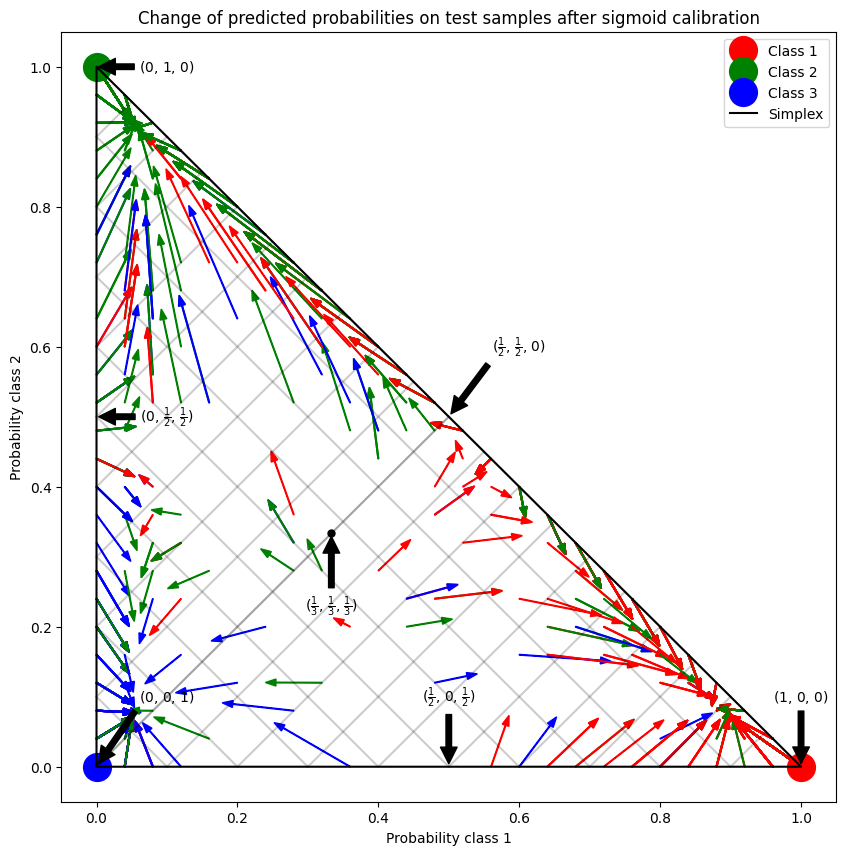

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
colors = ["r", "g", "b"]

clf_probs = clf.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")
plt.plot([0.0], [0.0], "bo", ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

# Log-loss Comparison

We compare the log loss of the uncalibrated and calibrated classifiers on the predictions of the 1000 test samples.

In [5]:
from sklearn.metrics import log_loss

score = log_loss(y_test, clf_probs)
cal_score = log_loss(y_test, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 1.327
 * calibrated classifier: 0.549


# Generate Grid and Plot

We generate a grid of possible uncalibrated probabilities over the 2-simplex, compute the corresponding calibrated probabilities and plot arrows for each. The arrows are colored according to the highest uncalibrated probability. This illustrates the learned calibration map:

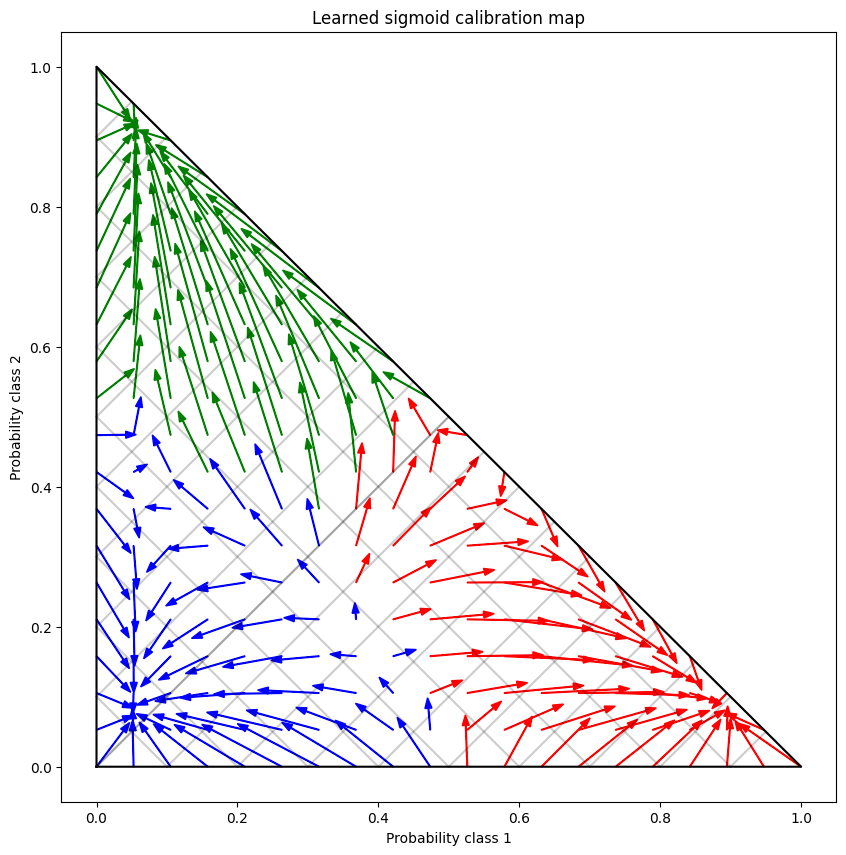

In [6]:
plt.figure(figsize=(10, 10))
# Generate grid of probability values
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

# Use the three class-wise calibrators to compute calibrated probabilities
calibrated_classifier = cal_clf.calibrated_classifiers_[0]
prediction = np.vstack(
    [
        calibrator.predict(this_p)
        for calibrator, this_p in zip(calibrated_classifier.calibrators, p.T)
    ]
).T

# Re-normalize the calibrated predictions to make sure they stay inside the
# simplex. This same renormalization step is performed internally by the
# predict method of CalibratedClassifierCV on multiclass problems.
prediction /= prediction.sum(axis=1)[:, None]

# Plot changes in predicted probabilities induced by the calibrators
for i in range(prediction.shape[0]):
    plt.arrow(
        p[i, 0],
        p[i, 1],
        prediction[i, 0] - p[i, 0],
        prediction[i, 1] - p[i, 1],
        head_width=1e-2,
        color=colors[np.argmax(p[i])],
    )

# Plot the boundaries of the unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Learned sigmoid calibration map")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()

# Summary

This lab showed how to use sigmoid calibration for 3-class classification in Python using scikit-learn. It demonstrated the impact of calibration on predicted probabilities and how it can be used to improve model performance.